In [5]:
# Plot a market
import matplotlib.pyplot as plt 
data = db.read("INXZ-23SEP14-T4467.44")
ob = [i for i in data]
bbos = [(o.get_bbo(), o.ts) for o in ob]
bids = [(o.bid,ts) for o,ts in bbos if o is not None]
bids = [(o.price, ts) for o, ts in bids if o is not None]
asks =  [(o.ask,ts) for o,ts in bbos if o is not None]
asks = [(o.price,ts) for o,ts in asks if o is not None]
plt.scatter([ts for _, ts in bids], [p for p, _ in bids])
plt.scatter([ts for _, ts in asks], [p for p, _ in asks])
plt.show()

NameError: name 'db' is not defined

In [1]:
import datetime
####### START HERE ############
from data.coledb.coledb import ColeDBInterface
date = "2023-11-28"
end_time = "16:00:00"  # 4 pm
datetime_str = f"{date} {end_time}"
dt_object = datetime.datetime.strptime(datetime_str, "%Y-%m-%d %H:%M:%S")
formatted_date = dt_object.strftime('%y%b%d').upper()
close_time_unix = int(dt_object.timestamp())
filename = f"/Users/kamyarghiam/Desktop/kalshi_bot/src/data/local/research/bbo_INXZ_and_SPY_{date}.csv"
from data.coledb.coledb import ColeDBInterface
db = ColeDBInterface()
cole_db_path = db.cole_db_storage_path / f"INXZ/{formatted_date}"
market_suffix = list(cole_db_path.iterdir())[0].name
price_threshold = float(market_suffix[1:])*10

In [88]:
# Create file ONLY RUN THIS ONCE
assert False
from strategy.utils import get_spy_ob_bbo_merged_df
from helpers.types.markets import MarketTicker
date_no_hyphen = date.replace("-","")
df = get_spy_ob_bbo_merged_df(db, f"/Users/kamyarghiam/Desktop/kalshi_bot/src/data/local/databento/xnas-itch/spy/xnas-itch-{date_no_hyphen}.mbo.csv", MarketTicker(f"INXZ-{formatted_date}-{market_suffix}"))
df.to_csv(filename)

AssertionError: 

1. first clean data, remove rows with nan spy. Then, divide spy price by 10000000 (to convert to cents). Take all times between 9:30 AM an d 4 PM
2. lag ES data by certain amount of time (maybe 0 seconds, 500 millis, 1 second, 2 seconds, 3 seconds, 4 seconds, 5 seconds, 10 seconds)
3. for each lagged df, tune hyper params 
4. params to tune are: m,b, and shift_up

In [2]:

# Load data (instead of creating)
import pandas as pd

# LOAD DATA
df = pd.read_csv(filename)

# First remove any rows with nan spy (cleaned_df)
cdf = df[df['spy_price'].notna()]
cdf['spy_price'] /= 10000000
cdf = cdf[(cdf.ts >= close_time_unix - 23400) & (cdf.ts <= close_time_unix)]
cdf = cdf[((cdf.yes_bid_price).notna()) & ((cdf.yes_ask_price).notna())]
cdf['spy_price_expanding_std_dev'] = cdf.spy_price.expanding().std()
# Next (skipped) lag the data
...


/var/folders/bq/3lxf2pcx7s9crrr7kqds7d_00000gn/T/ipykernel_22236/1883981032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf['spy_price'] /= 10000000


Ellipsis

In [42]:
import numpy as np
from scipy.optimize import basinhopping, minimize


def get_cdf_with_params(x):
    m = x[0]
    b = x[1]
    shift_up = x[2]
    c = x[3]
    d = x[4]
    """Minimization functions for the bids"""
    diff = close_time_unix - cdf.ts
    cdf['w'] = m *((diff)**c) + d * diff + b
    cdf['sigmoid'] = (1 / (1 + np.exp(-1*(price_threshold - cdf.spy_price)* (cdf.w)))) + shift_up
    return cdf

def minimize_bids(x):
    cdf = get_cdf_with_params(x)
    # Adjust below for bids (yes_ask_price)
    return abs((100*cdf.sigmoid) - cdf.yes_bid_price).sum()
def callback(x, f=None, accepted= None):
    print(f"Iteration {callback.iteration}: x = {x}, f(x) = {f}, accepted = {accepted}")
    callback.iteration += 1
callback.iteration = 0
# Nelder-Mean method
result = minimize(
        minimize_bids,
        [3.45340156e-06, -1.01846140e-02,  4.92236515e-02,  1.07880840e+00,
 -7.41238138e-06],
        method="Nelder-Mead",
        callback=callback

    )
# Best so far:
# 9/14/23 -- 104577
# 10/02/23 -- 456965
# 10/18/23 -- 170952
# 11/30/23 -- 857148.92
# [3.45340156e-06, -1.01846140e-02,  4.92236515e-02,  1.07880840e+00,-7.41238138e-06]
minimize_bids(result.x)

Iteration 0: x = [ 3.45340156e-06 -1.01846140e-02  4.92236515e-02  1.07880840e+00
 -7.41238138e-06], f(x) = None, accepted = None
Iteration 1: x = [ 3.45340156e-06 -1.01846140e-02  4.92236515e-02  1.07880840e+00
 -7.41238138e-06], f(x) = None, accepted = None
Iteration 2: x = [ 3.45340156e-06 -1.01846140e-02  4.92236515e-02  1.07880840e+00
 -7.41238138e-06], f(x) = None, accepted = None
Iteration 3: x = [ 3.45340156e-06 -1.01846140e-02  4.92236515e-02  1.07880840e+00
 -7.41238138e-06], f(x) = None, accepted = None
Iteration 4: x = [ 3.45340156e-06 -1.01846140e-02  4.92236515e-02  1.07880840e+00
 -7.41238138e-06], f(x) = None, accepted = None
Iteration 5: x = [ 3.45340156e-06 -1.01846140e-02  4.92236515e-02  1.07880840e+00
 -7.41238138e-06], f(x) = None, accepted = None
Iteration 6: x = [ 3.45340156e-06 -1.01846140e-02  4.92236515e-02  1.07880840e+00
 -7.41238138e-06], f(x) = None, accepted = None
Iteration 7: x = [ 3.45340156e-06 -1.01846140e-02  4.92236515e-02  1.07880840e+00
 -7.4123

857148.920417511

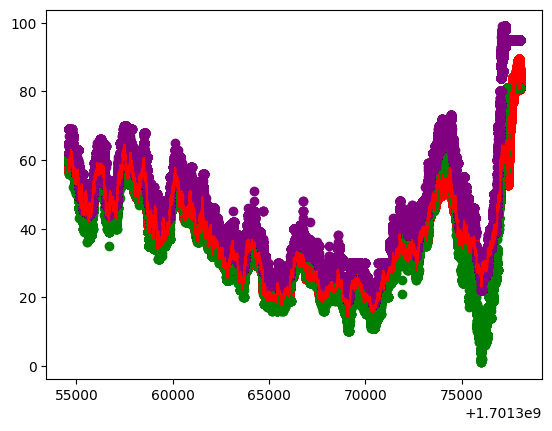

In [43]:
import matplotlib.pyplot as plt 
cdf_with_params = get_cdf_with_params(result.x)

plt.plot(cdf_with_params.ts, cdf_with_params.sigmoid*100, color = 'red')
plt.scatter(cdf_with_params.ts, cdf_with_params.sigmoid*100, color = 'red')
plt.scatter(cdf_with_params.ts, cdf_with_params.yes_bid_price, color ='green')
plt.scatter(cdf_with_params.ts, cdf_with_params.yes_ask_price, color = 'purple')
plt.show()

##### TODO:

1. (done) Figure out good bounds for hyper params -- it's returning the same values everywhere (find out why). You might need to use diff optimizations
2. **TODO** figure out why it's inversely correlated
3. Run for asks as well 
4. Finally, try to lag the data some time 

In [5]:
price = cdf.spy_price
time = cdf.ts
output = cdf.yes_bid_price

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define a logistic function with a time-dependent parameter
def time_dependent_logistic(x, k, t):
    return 1 / (1 + np.exp(-k * (x - t)))

# TODO: I replaced variables below with my actual data 
y = time_dependent_logistic(price, k=5 * time, t=2) + 0.05 * np.random.randn(100)

# Fit the time-dependent logistic function to the data
popt, pcov = curve_fit(time_dependent_logistic, X, y, bounds=([0, 0], [np.inf, np.inf]))

# Generate predictions using the fitted parameters
X_test = np.linspace(min(X), max(X), 300)
y_pred = time_dependent_logistic(X_test, *popt)

# Plot the original data and the fitted logistic curve
plt.scatter(X, y, label='Original data')
plt.plot(X_test, y_pred, label='Fitted time-dependent logistic curve', color='red', linewidth=2)
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.show()


ValueError: operands could not be broadcast together with shapes (217305,) (100,) 

In [17]:
output_df = pd.DataFrame({"x": price, "time": time, "y": output})

In [18]:
# From 11/28
output_df.to_csv("/Users/kamyarghiam/Desktop/kalshi_bot/src/data/local/research/11_30_spy_price_to_kalshi_time.csv", index=False)

In [7]:
import numpy as np
import pandas as pd
df = pd.read_csv( "/Users/kamyarghiam/Desktop/kalshi_bot/src/data/local/research/11_28_spy_price_to_kalshi_time.csv")

In [8]:
df['x'] -= price_threshold

<Axes: >

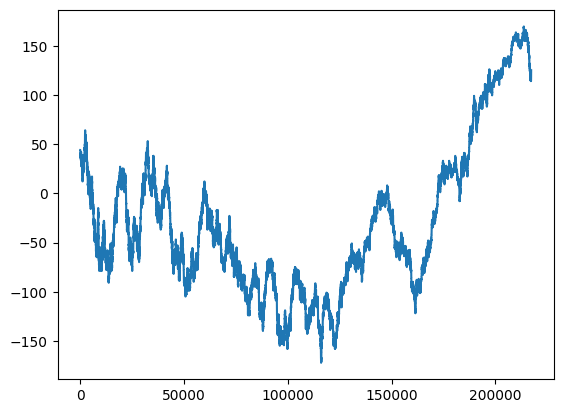

In [9]:
df.x.plot()

In [10]:
df

,x,time,y
0,44.2,1.701355e+09,61.0
1,44.2,1.701355e+09,61.0
2,44.2,1.701355e+09,61.0
3,44.2,1.701355e+09,61.0
4,44.2,1.701355e+09,61.0
...,...,...,...
217300,125.2,1.701378e+09,81.0
217301,125.2,1.701378e+09,81.0
217302,125.2,1.701378e+09,81.0
217303,125.2,1.701378e+09,81.0


In [11]:
# Curve to be fitted (for ONE dataset)
def func( x_time_tup, x0, c):
    xval = x_time_tup[0]
    time = x_time_tup[1]
    return (np.tanh( c * ( xval - x0 ) * time) + 1)*50

In [12]:
# Normalize time column
df['time'] = (df.time - df.time.min())

In [35]:
from scipy.optimize import curve_fit
p0 = [ 0, 0.001]
start = -100000
end = -1
params, cv = curve_fit( func, (df.x.iloc[start:end], df.time.iloc[start:end]), df.y.iloc[start:end],p0=p0)
params

array([-1.70388267e+01,  3.99278051e-07])

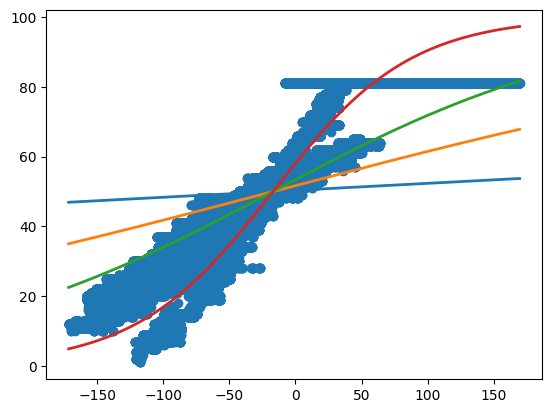

In [36]:
xtest =  np.linspace( df.x.min(), df.x.max(), 2000 )
time_test = np.linspace( df.time.min(), df.time.max(), 2000 )
ytest = [func((x,t), *params) for x,t in zip(xtest,[1000]*2000)]
import matplotlib.pyplot as plt
plt.plot( xtest, ytest, linewidth=2)

ytest = [func((x,t), *params) for x,t in zip(xtest,[5000]*2000)]
import matplotlib.pyplot as plt
plt.plot( xtest, ytest, linewidth=2)

ytest = [func((x,t), *params) for x,t in zip(xtest,[10000]*2000)]
import matplotlib.pyplot as plt
plt.plot( xtest, ytest, linewidth=2)

ytest = [func((x,t), *params) for x,t in zip(xtest,[24000]*2000)]
import matplotlib.pyplot as plt
plt.plot( xtest, ytest, linewidth=2)

plt.scatter( df.x, df.y,)

plt.show()

In [34]:
# TODO try it on a different day? Maybe calculate loss? Maybe calculate prediction vs actual???? bruh

# Actual TODO: graph kalshi prices and model

In [28]:
df.time

0             0.000000
1             0.000000
2             0.000000
3             0.000000
4             0.000000
              ...     
217300    23399.965708
217301    23399.966196
217302    23399.966196
217303    23399.968067
217304    23399.968067
Name: time, Length: 217305, dtype: float64

In [37]:
df['pred'] = func((df.x, df.time), *params)

In [16]:
shifts = [i for i in range(50,100)]
losses = []
for i in shifts:
    print(i)
    df["x_shift"] = df.x.shift(i)
    new_df = df.dropna()
    p0 = [ 0, 0.001]
    params, cv = curve_fit( func, (new_df.x_shift, new_df.time), new_df.y,p0=p0)
    df['pred'] = func((new_df.x_shift, new_df.time), *params)
    loss = sum(abs(new_df.pred - new_df.y))
    losses.append(loss)

50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


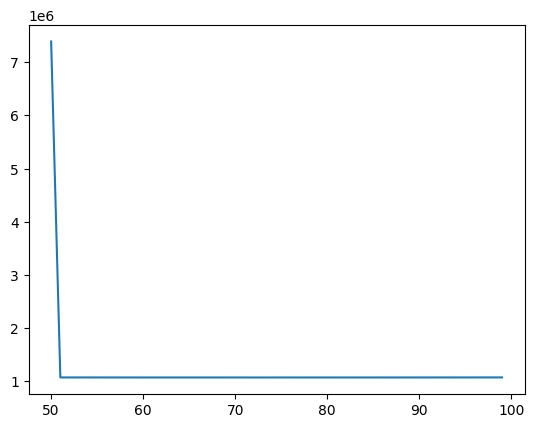

In [17]:
import matplotlib.pyplot as plt 
plt.plot(shifts, losses)
plt.show()

# Around 62 shifts, we minimize the loss!

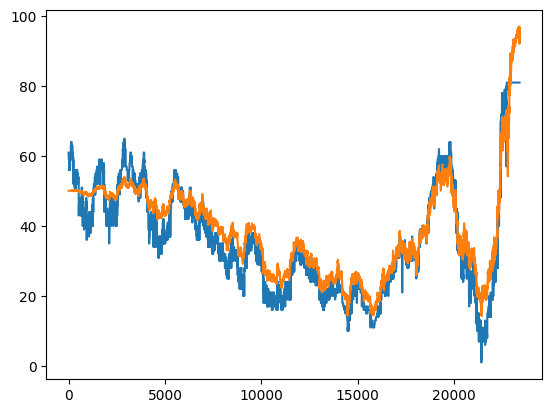

In [38]:
import matplotlib.pyplot as plt 

plt.plot(df.time, df.y)
plt.plot(df.time, df.pred)
plt.show()

In [ ]:
# Maybe run a mini sim here. Loop through pandas array and buy and sell where appropraite

In [1]:
# Curve with a time shift of 62 steps 
shift = 62
df["x_shift"] = df.x.shift(shift)
new_df = df.dropna()
p0 = [ 0, 0.001]
params, cv = curve_fit( func, (new_df.x_shift, new_df.time), new_df.y,p0=p0)
df['pred'] = func((new_df.x_shift, new_df.time), *params)

plt.plot(df.time, df.y)
plt.plot(df.time, df.pred)
plt.show()


NameError: name 'df' is not defined

In [34]:
# Get average time difference from 62 shifts also clean up your damn code
# It's around 2 to 11 seconds ahead 
(df.time - df.time.shift(62)).describe()

count    217243.000000
mean          6.678162
std           5.563006
min           0.000012
25%           2.166020
50%           5.527853
75%           9.779015
max          42.604245
Name: time, dtype: float64

In [ ]:
# Plan, train on the fly, on a 10000 step sliding window. Every 5000 steps, retrain params. Initial params will be yesterday's data
# Set omega to 0.5 to capture market data
# The Model prediction should aim to predict roughly 2 seconds into the future 

# Next to do: let's clean up this notebook so we can do cleaner research.
# Maybe see if you can shift the pandas df by time (instead of by row)